# Africa Soil Property Prediction Challenge
Predict physical and chemical properties of soil using spectral measurements

# Data Loading and Cleansing 

All libraries are loaded here. The training file is read and the columns in spectra CO2 bands which are in the region m2379.76 to m2352.76 are removed. 
As a part of data preprocessing, categorical variables are converted to numeric using onehot encoding . Smoothening and Derivative of the data are performed for optimizing.

In [ ]:
import pandas as pd  
import numpy 
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as sm
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import time
import numpy as np
start_time = time.time()

#loading the training dataset
df=pd.read_csv('training.csv')

#dropping columns in spectral band of Co2 
df=df.drop(df.loc[:, 'm2379.76':'m2352.76'].columns, axis = 1) 

#one hot coding for soil type
soil= df.Depth.str.get_dummies()
df =pd.concat([df,soil],axis=1) 

#smoothening of dataset using savgol filter
spectra= [m for m in list(df.columns) if m[0]=='m'] 
smoothed_2dg = savgol_filter(df[spectra], window_length = 11, polyorder = 3, deriv=1)
df_smooth=pd.DataFrame(smoothed_2dg,columns=spectra)
df[spectra]=df_smooth

#derivative 
train_smooth_1stderiv=df_smooth
smoothed_1dg = savgol_filter(train_smooth_1stderiv[spectra], window_length = 11, polyorder = 3, deriv=1) #running poliamial smoother with deravatives 1
smooth_train1=pd.DataFrame(smoothed_1dg,columns=spectra)
df[spectra]=smooth_train1

The overall feature reduction using standard deviation is performed and for further feature selection process of each target variable, the correlation matrix is calculated

In [ ]:
#Features below the threshold of 0.003 are dropped 
threshold = 0.003
df.drop(df.std()[df.std() < threshold].index.values, axis=1)

#The correlation matrix is calculated for the feature elimination using correlation.
c = df.corr().abs()

# Feature selection and Prediction of Target Variables
Feature selections and modelings are customized to each target variable for lower MSE and higher accuracy. Five different models are used to predict Five target variables considering the fact that there is no severe correlation between any of the five target variables. The below heatmap shows there is no significant correlation between any target variables.

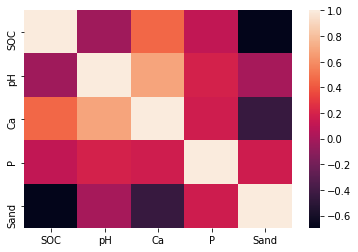

In [ ]:
#dataframe contining the 5 target variables
target=df[['SOC', 'pH', 'Ca', 'P', 'Sand']]
#Spearman cofficient is considered as the data isnt linear
tarcor=target.corr(method='spearman')
#creation of heatmap
sns.heatmap(tarcor,       
            xticklabels=tarcor.columns.values,
            yticklabels=tarcor.columns.values) 
plt.show()

# Feature selection and Prediction of Calcium

Eliminating features having low correlation:
The columns of target variable (here Ca) in the correlation matrix is considered and about 20% of data is deleted based on low correlation.The correlation threshold is defined based on the 20% data that needs to be filtered.
Feature Selection Using Random Forest considers the importance matrix and the features with standard deviation above the threshold is selected.
Pricipal Component analysis is further performed to transform the variables from one cordinate system to another. Post the features are selected the model is trained and Calcium is predicted.

In [ ]:
# eliminating features having low correlation
#The columns Ca in the correlation matrix is considered and about 20% of data is deleted based on low correlation.
#The correlation threshold is defined based on the 20% data that needs to be filtered.
ca=c[['Ca']]
ca=ca[ca['Ca'] >0.25].reset_index()
feat_ca=list(ca['index'].unique())
df_ca=df[[*feat_ca]]
#The Target variables are deleted from the dataframe and this is used used for further feature selection/elimination process
df_ca=df_ca.drop([ 'pH', 'SOC', 'Sand','Ca'], axis = 1)

#Feature Selection Using Random Forest : This focuses on deriving the importance matrix
#The features with standard deviation above the threshold is selected 
X=df_ca.copy()
y=df.Ca
col = list(X.columns)
clf = RandomForestRegressor (n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X,y)
sfm = SelectFromModel(clf, threshold=0.0001)
sfm.fit(X,y)
list1 = []
for feature_list_index in sfm.get_support(indices=True):
    list1.append(col[feature_list_index])
X=X[[*list1]]

#Pricipal Component analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # splitting of dataframe to train and test
sc = StandardScaler() # Standardization is performed for normalization of features
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components=len(list1)) # On obtaining the most important features of Ca, the lest of columns is given as input for the number of components.
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#Modeling using Random Forest
base_model = RandomForestRegressor(n_estimators = 100, random_state = 42) 
base_model.fit(X_train, y_train)
y_predicted = base_model.predict(X_test)
y_test = y_test.to_numpy()
calcium=np.sqrt(mean_squared_error(y_test, y_predicted))
print('MSE for Calcium : ', calcium)

MSE for Calcium :  0.3532230974057284


# Feature selection and Prediction of phosphorus

Eliminating features having low correlation based on the threshold, PCA etc are similar to that of Calcium. The feature selection methods used in Calcium is extended varying the thresholds for different Target variables. Post feature selection, The model is trained and the target values are predicted for the remaining four variables.

In [ ]:
# eliminating features having low correlation
#The columns P in the correlation matrix is considered and about 20% of data is deleted based on low correlation.
#The correlation threshold is defined based on the 20% data that needs to be filtered.
p = c.copy()
pa=p[['P']]
pa=pa[pa['P'] > 0.1].reset_index()
feat_pa=list(pa['index'].unique())
df_pa=df[[*feat_pa]]
#The Target variables are deleted from the dataframe and this is used used for further feature selection/elimination process
df_pa=df_pa.drop(['P'], axis = 1)
#Feature Selection Using Random Forest : This focuses on deriving the importance matrix
#The features with standard deviation above the threshold is selected 
X=df_pa.copy()
y=df.P
col = list(X.columns)
clf = RandomForestRegressor (n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X,y)
sfm = SelectFromModel(clf, threshold=0.0001)
sfm.fit(X,y)
list1 = []
for feature_list_index in sfm.get_support(indices=True):
    list1.append(col[feature_list_index])
X1=X[[*list1]]

#Pricipal Component analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)# splitting of dataframe to train and test
sc = StandardScaler() # Standardization is performed for normalization of features
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components=13)# On obtaining the most important features of P, the number of columns with very high standard deviation is considered.
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#Modeling using Random Forest
base_model =  RandomForestRegressor (n_estimators=100, random_state=0, n_jobs=-1)
base_model.fit(X_train, y_train)
y_predicted = base_model.predict(X_test)
y_test = y_test.to_numpy()
phosphorous=np.sqrt(mean_squared_error(y_test, y_predicted))
print('MSE for P : ', phosphorous)

# Feature selection and Prediction of Sand

In [ ]:
# eliminating features having low correlation
#The columns Sand in the correlation matrix is considered and about 20% of data is deleted based on low correlation.
#The correlation threshold is defined based on the 20% data that needs to be filtered.
s = c.copy()
sa=s[['Sand']]
sa=sa[sa['Sand'] >0.10].reset_index()
feat_sa=list(sa['index'].unique())
df_sa=df[[*feat_sa]]
#The Target variables are deleted from the dataframe and this is used used for further feature selection/elimination process
df_sa=df_sa.drop(['SOC', 'Sand','Ca'], axis = 1)
#Feature Selection Using Random Forest : This focuses on deriving the importance matrix
#The features with standard deviation above the threshold is selected 
X=df_sa.copy()
y=df.Sand
col = list(X.columns)
clf = RandomForestRegressor (n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X,y)
sfm = SelectFromModel(clf, threshold=0.00025)
sfm.fit(X,y)
list1 = []
for feature_list_index in sfm.get_support(indices=True):
    list1.append(col[feature_list_index])

X=X[[*list1]]
#RFE automatic number of features selected
rfecv1 = RFECV(estimator=DecisionTreeRegressor(), step=1, cv=5)
rfecv1 = rfecv1.fit(X, y)
rfecv1_rank_list = list(rfecv1.ranking_)
indices = [i for i, x in enumerate(rfecv1_rank_list) if x == 1]
list2 = [list1[i] for i in indices]
X=X[[*list2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#Modeling using Random Forest
base_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
base_model.fit(X_train, y_train)
y_predicted = base_model.predict(X_test)
y_test = y_test.to_numpy()

sand=np.sqrt(mean_squared_error(y_test, y_predicted))
print('MSE for Sand : ', sand)

MSE for Sand :  0.28676026080505673


## Feature selection and Prediction of pH

In [ ]:
# eliminating features having low correlation
#The columns pH in the correlation matrix is considered and about 20% of data is deleted based on low correlation.
#The correlation threshold is defined based on the 20% data that needs to be filtered.
ph=c[['pH']]
ph=ph[ph['pH'] >0.25].reset_index()
feat_ph=list(ph['index'].unique())
df_ph=df[[*feat_ph]]
#The Target variables are deleted from the dataframe and this is used used for further feature selection/elimination process
df_ph=df_ph.drop([ 'pH','Ca'], axis = 1)
#Feature Selection Using Random Forest : This focuses on deriving the importance matrix
#The features with standard deviation above the threshold is selected 
X_ph=df_ph.copy()
y_ph=df.pH
col_ph = list(X_ph.columns)
clf_ph = RandomForestRegressor (n_estimators=150, random_state=0, n_jobs=-1)
clf_ph.fit(X_ph,y_ph)
sfm_ph = SelectFromModel(clf_ph, threshold=0.001)
sfm_ph.fit(X_ph,y_ph)
list1_ph = []
for feature_list_index_ph in sfm_ph.get_support(indices=True):
    list1_ph.append(col_ph[feature_list_index_ph])
X_ph=X_ph[[*list1_ph]]

X_train_ph, X_test_ph, y_train_ph, y_test_ph = train_test_split(X_ph, y_ph, test_size=0.2, random_state=0)# splitting of dataframe to train and test
# Standardization is performed for normalization of features
df_pf_pa=df_ph.copy()
sc_ph = StandardScaler()
X_train_ph = sc_ph.fit_transform(X_train_ph)
X_test_ph = sc_ph.transform(X_test_ph)

#Pricipal Component analysis
pca_ph = PCA(n_components=len(list1_ph))# On obtaining the most important features of pH, the lest of columns is given as input for the number of components.
X_train_ph = pca_ph.fit_transform(X_train_ph)
X_test_ph = pca_ph.transform(X_test_ph)

#Modeling using Random Forest
base_model_ph = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model_ph.fit(X_train_ph, y_train_ph)
y_predicted_ph = base_model_ph.predict(X_test_ph)
ph_mse=np.sqrt(mean_squared_error(y_test_ph, y_predicted_ph))
print('MSE for pH : ', ph_mse)

MSE for pH :  0.41466307615693226


#  Feature selection and Prediction of SOC

In [ ]:
# eliminating features having low correlation
#The columns SOC in the correlation matrix is considered and about 20% of data is deleted based on low correlation.
#The correlation threshold is defined based on the 20% data that needs to be filtered.
so = c.copy()
soc=so[['SOC']]
soc=soc[soc['SOC'] >0.1].reset_index()
feat_soc=list(soc['index'].unique())
df_soc=df[[*feat_soc]]
#The Target variables are deleted from the dataframe and this is used used for further feature selection/elimination process
df_soc=df_soc.drop([ 'Sand','SOC','P','Ca'], axis = 1)
#Feature Selection Using Random Forest : This focuses on deriving the importance matrix
#The features with standard deviation above the threshold is selected 
X=df_soc.copy()
y=df.SOC
col = list(X.columns)
clf = RandomForestRegressor (n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X,y)
sfm = SelectFromModel(clf, threshold=0.00025)
sfm.fit(X,y)
list1 = []
for feature_list_index in sfm.get_support(indices=True):
    list1.append(col[feature_list_index])
X1=X[[*list1]]

#Pricipal Component analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)# splitting of dataframe to train and test
sc = StandardScaler() # Standardization is performed for normalization of features
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca = PCA(n_components=40)# On obtaining the most important features of SOC, the number of columns with very high standard deviation
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#Modeling using Random Forest
base_model = RandomForestRegressor(n_estimators = 250, random_state = 42)
base_model.fit(X_train, y_train)
y_predicted = base_model.predict(X_test)
y_test = y_test.to_numpy()
soc_mse=np.sqrt(mean_squared_error(y_test, y_predicted))
print('MSE for SOC : ', soc_mse)

MSE for SOC :  0.5225929533281287


# Metric Evaluation : Calculation of MCRMSE

After each model is evaluated, the root mean square is calculated for each of the five target variables. The overall performance is calculated by computing the mean of  error of each target variable, called the mean column wise root mean square error (MCRMSE).


In [ ]:
# The MSE from each of the variables is cumulated and divided by 5 (average taken)
sum_of_errors=calcium+phosphorous+ph_mse+sand+soc_mse
MCRMSE=sum_of_errors/5

print()
print('Mean Columnwise Root Mean Square Erro (MCRMSE) : ', MCRMSE)
print()
print("---Total runtime %s seconds ---" % (time.time() - start_time))



Mean Columnwise Root Mean Square Erro (MCRMSE) :  0.5155379089281054

---Total runtime 970.2963027954102 seconds ---
